In [35]:
import pandas as pd
cnn_df=pd.read_csv('after_bert1_data_to_compare.csv')

In [36]:
cnn_df.head()

,Email Text,Email Type,BERT Embeddings
0,breathtaking image for your company now workin...,Phishing Email,[ 2.01383844e-01 6.47791803e-01 8.92811060e-...
1,how to substantially increase saleseasily acce...,Phishing Email,[ 3.55392471e-02 6.76252171e-02 4.91976410e-...
2,epac pt e carnoali genie com e carolan genie c...,Phishing Email,[-1.55056268e-03 1.29966527e-01 5.61987758e-...
3,about aptconf there are these lines rpm leave ...,Safe Email,[ 2.52865672e-01 3.50500196e-01 9.46413457e-...
4,cialis soft tabs pre scriptions new clalls sof...,Phishing Email,[-1.62849613e-02 -6.34869561e-02 7.19620764e-...


In [37]:
cnn_df.describe()

,Email Text,Email Type,BERT Embeddings
count,13114,13116,13116
unique,13020,2,12984
top,alink texdecoration noneaactive textdecoration...,Phishing Email,[-7.23443851e-02 1.28986150e-01 4.14267689e-...
freq,6,6558,9


In [38]:
# Check the first few rows of the BERT Embeddings column
print(cnn_df['BERT Embeddings'].head())

# Check the type of the first entry in the BERT Embeddings column
print(type(cnn_df['BERT Embeddings'][0]))


0    [ 2.01383844e-01  6.47791803e-01  8.92811060e-...
1    [ 3.55392471e-02  6.76252171e-02  4.91976410e-...
2    [-1.55056268e-03  1.29966527e-01  5.61987758e-...
3    [ 2.52865672e-01  3.50500196e-01  9.46413457e-...
4    [-1.62849613e-02 -6.34869561e-02  7.19620764e-...
Name: BERT Embeddings, dtype: object
<class 'str'>


In [39]:
def fix_embedding_format(embedding_str):
    # Replace spaces with commas, ensuring proper formatting for lists
    return '[' + ','.join(embedding_str.strip('[]').split()) + ']'

# Apply the formatting fix
cnn_df['BERT Embeddings'] = cnn_df['BERT Embeddings'].apply(fix_embedding_format)


In [40]:
import ast
import numpy as np

# Convert string embeddings to actual NumPy arrays
cnn_df['BERT Embeddings'] = cnn_df['BERT Embeddings'].apply(lambda x: np.array(ast.literal_eval(x)))


In [41]:
print(type(cnn_df['BERT Embeddings'][0]))  # Should output <class 'numpy.ndarray'>
print(cnn_df['BERT Embeddings'][0].shape)  # Should show the shape of the embedding


<class 'numpy.ndarray'>
(768,)


In [46]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Initialize a list to store the cleaned embeddings
X_cleaned = []

for emb in cnn_df['BERT Embeddings']:
    try:
        # Ensure emb is a valid numpy array
        if isinstance(emb, np.ndarray):
            # Remove 'Ellipsis' from the embedding
            emb = emb[emb != Ellipsis]
            
            # Filter out zero values
            non_zero_emb = emb[emb != 0]
            
            # Only keep embeddings that have at least one non-zero value
            if non_zero_emb.size > 0:
                X_cleaned.append(non_zero_emb)
            else:
                print(f"Skipping embedding with no non-zero values after cleaning: {emb}")
        else:
            print(f"Skipping invalid entry (not numpy array): {emb}")
            continue
    except Exception as e:
        print(f"Skipping invalid entry due to error: {e}")
        continue

# Convert the cleaned list into a numpy array
X_cleaned = np.array(X_cleaned)

# Ensure that we have enough valid data
if X_cleaned.size == 0:
    print(f"Total number of valid embeddings: {len(X_cleaned)}")
    raise ValueError("No valid embeddings found after cleaning. Please check the data.")

# Proceed with the remaining steps as before (e.g., train-test split)
y = cnn_df['Email Type']
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = tf.keras.utils.to_categorical(y, num_classes=2)

# Reshape X to make it 3D for CNN input (num_samples, time_steps=1, embedding_dim)
X_cleaned = np.expand_dims(X_cleaned, axis=1)

# Train-Test Split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y, test_size=0.2, random_state=42)

# Cast X_train and X_test to float32 to avoid data type issues
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

# Check the shapes of the data
print(f"Shape of X_train: {X_train.shape}")  # Should be (num_samples, 1, embedding_dim)
print(f"Shape of y_train: {y_train.shape}")  # Should be (num_samples, 2)


Shape of X_train: (10492, 1, 768)
Shape of y_train: (10492, 2)


In [47]:
# Cast X_train and X_test to float32 to avoid data type issues
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)


In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, Input

# Build CNN Model with Input Layer
model = Sequential([
    Input(shape=X_train.shape[1:]),  # Explicit input layer with shape (1, 7)
    Conv1D(filters=64, kernel_size=1, activation='relu'),  # kernel_size=1 for single time step
    Dropout(0.5),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

# Retrieve weights after the last epoch
# final_weights = model.get_weights()
# model.save('cnn_model.h5')

# # Print weights of each layer
# for i, layer_weights in enumerate(final_weights):
#     print(f"Weights of Layer {i + 1}:")
#     print(layer_weights)
#     print("-" * 50)


Epoch 1/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7895 - loss: 0.4331 - val_accuracy: 0.9457 - val_loss: 0.1394
Epoch 2/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9400 - loss: 0.1718 - val_accuracy: 0.9414 - val_loss: 0.1513
Epoch 3/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9459 - loss: 0.1524 - val_accuracy: 0.9543 - val_loss: 0.1167
Epoch 4/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9487 - loss: 0.1414 - val_accuracy: 0.9476 - val_loss: 0.1319
Epoch 5/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9563 - loss: 0.1230 - val_accuracy: 0.9566 - val_loss: 0.1126
Epoch 6/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9534 - loss: 0.1252 - val_accuracy: 0.9571 - val_loss: 0.1067
Epoch 7/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9543 - loss: 0.1201 - val_accuracy: 0.9614 - val_loss: 0.1034
Epoch 8/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9578 - loss: 0.1120 - val_accuracy: 0.

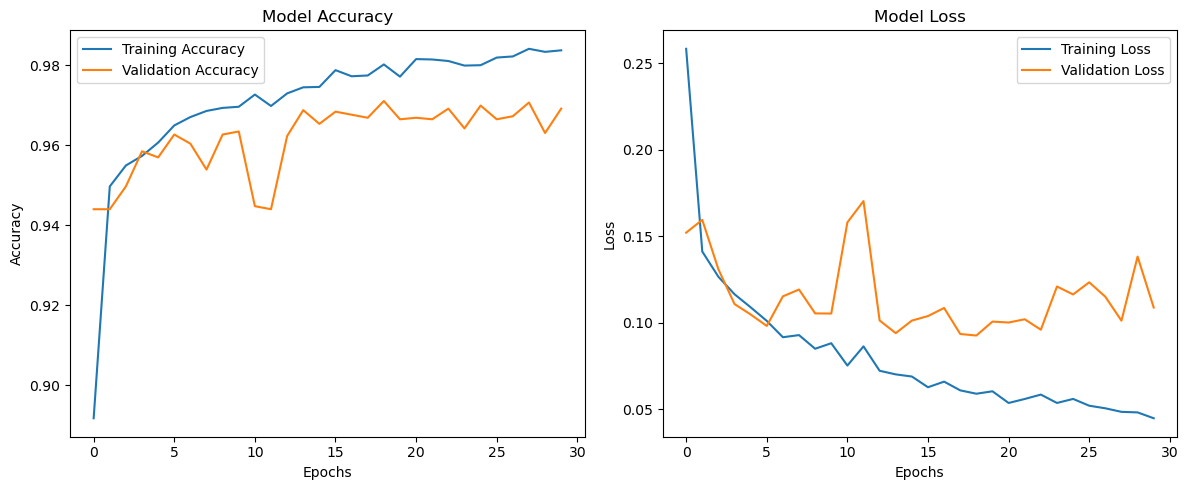

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()